To launch in SuperCloud from a Computed Node


LLsub -i full #for an exclusive node

LLsub -i -s 40 #for node with 40 CPUs

LLsub -i -s 40 -g volta:1 #for node with 40 CPUs and 1 Volta GPU

salloc  --job-name=interactive --qos=high --time=00:60:00 --partition=debug-gpu --gres=gpu:volta:1 --cpus-per-task=40 srun    --pty bash -i

module load anaconda/2023a-pytorch

jupyter lab --no-browser --ip=0.0.0.0 --port=8890

Latest server: http://d-7-1-1:8890/lab?token=8da209fe172745ecf7f18de35d58e60947ce9616a41f44b9

In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dgd.utils.utils5 import *
import pickle
import pandas as pd
import json
import networkx as nx
from tqdm.notebook import tqdm
import time
#import gymnasium as gym
#from gymnasium import spaces
import subprocess
import multiprocessing
import concurrent.futures
import os
import random
from collections import defaultdict
import socket

import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import cycle
from pathlib import Path
import time
from sklearn.metrics import mean_squared_error, r2_score
import csv


In [2]:
def small_topology_plot(graph_networkx):
    pos = nx.spring_layout(graph_networkx)
    color = 'lightblue'
    plt.figure(figsize=(3, 3))
    nx.draw(graph_networkx, pos, with_labels=False, node_color=color, node_size=250, font_size=10, font_weight='bold')
    nx.draw_networkx_labels(graph_networkx, pos, font_size=8, font_color='black')
    plt.show()   

def topology_plot_with_attrs(G, node_attr = None, edge_attr = None, seed=42):

    if node_attr is None:
        first_node_attrs = next(iter(G.nodes(data=True)), (None, {}))[1]
        node_attr = next(iter(first_node_attrs), None)

    if edge_attr is None:
        for _, _, d in G.edges(data=True):
            if d:
                edge_attr = next(iter(d))
                break


    pos = nx.spring_layout(G, seed=seed)
    plt.figure(figsize=(5, 5)); plt.axis("off")


    node_labels = {}
    default_colour = "lightblue"          
    node_colors   = default_colour

    if node_attr is not None:
        values = [G.nodes[n].get(node_attr) for n in G.nodes()]


        if all(isinstance(v, (int, float)) for v in values if v is not None):
            norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
            cmap = cm.get_cmap("viridis")
            node_colors = [cmap(norm(v)) for v in values]


        else:
            present_vals = {v for v in values if v is not None}

            unique_vals  = sorted(present_vals, key=lambda x: str(x))

            palette     = cycle(cm.tab20.colors)
            colour_map  = {val: next(palette) for val in unique_vals}
            missing_col = "#d3d3d3"                     # grey for None
            node_colors = [colour_map.get(v, missing_col) for v in values]


        for n in G.nodes():
            val = G.nodes[n].get(node_attr)
            node_labels[n] = f"{n}\n{node_attr}={val}"

    else:
        node_labels = {n: n for n in G.nodes()}


    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600)
    nx.draw_networkx_edges(G, pos, arrows=G.is_directed())
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)


    if edge_attr is not None:
        edge_labels = {
            (u, v): f"{edge_attr}={d.get(edge_attr)}"
            for u, v, d in G.edges(data=True) if edge_attr in d
        }
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)


    if node_attr and not all(isinstance(v, (int, float)) for v in values if v is not None):
        handles = [
            plt.Line2D([0], [0], marker="o", color="w",
                       markerfacecolor=colour_map[val], markersize=8,
                       label=str(val))
            for val in unique_vals
        ]
        if any(v is None for v in values):
            handles.append(
                plt.Line2D([0], [0], marker="o", color="w",
                           markerfacecolor=missing_col, markersize=8,
                           label="None")
            )
        plt.legend(title=node_attr, handles=handles,
                   bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout(); plt.show()

def permute_graph(graph, permutation):
    mapping = {old: new for old, new in zip(input_nodes, permutation)}
    permuted_graph = nx.relabel_nodes(graph, mapping)
    return permuted_graph

In [3]:
hostname = socket.gethostname()
print(f"Node: {hostname}")
num_gpus = th.cuda.device_count()
print(f"GPUs: {num_gpus}")
for idx in range(num_gpus):
    props = th.cuda.get_device_properties(idx)
    print(f"GPU {idx}: {props.name} "
          f"({props.total_memory // 1024**2} MB, "
          f"compute capability {props.major}.{props.minor})")
print(f"CPUs: {multiprocessing.cpu_count()}")


Node: d-7-1-1
GPUs: 1
GPU 0: Tesla V100-PCIE-32GB (32494 MB, compute capability 7.0)
CPUs: 80


#### Parameters

In [4]:
circuit_name = "0x0A"

#File with designs 
file_name = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250628_single_circuit_0x0A/seed_1/optimal_topologies/optimal_topologies.pkl"

#file_name = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/notebooks/0x2B_ML_topology_designs_reduced.pkl"

# Set up output directory
#output_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/notebooks/runs/0x2B/test/"


#Path(output_dir).mkdir(parents=True, exist_ok=True)

In [5]:
with open(file_name, "rb") as f:
    reduced_graphs = pickle.load(f)   
 
print(f"Number of biological circuits: {len(reduced_graphs)}")

Number of biological circuits: 4


In [6]:
type(reduced_graphs)

list

In [7]:
#Select graph in graphs
selected_graph = 0     

#It will compute valid permutations if True, otherwise it will try to load a prior computation    
compute_valid_permutations = False

num_samples = 25000           # Total valid permutations to process for trainning data
batch_size = 1000              # Size of each processing batch
solutions_per_file = 250000    # Number of solutions to save per file

In [8]:
# Variables for preparing data for training 
np.random.seed(42)
subsample_size = 25000
num_epochs = 300

In [9]:
topology_networkx = reduced_graphs[selected_graph] 

# Define the input nodes
input_nodes = [0, 1, 2]
# Generate all permutations of the input nodes
permutations = list(itertools.permutations(input_nodes))
# Create a list to store the permuted graphs
permuted_graphs = []

for perm in permutations:
    new_graph = permute_graph(topology_networkx, perm)

    if calculate_truth_table_v2(new_graph) == calculate_truth_table_v2(topology_networkx):
        idx = len(permuted_graphs)          
        print(f"Permuted graphs {idx}: {perm}")      
        permuted_graphs.append(new_graph)  
        

Permuted graphs 0: (0, 1, 2)


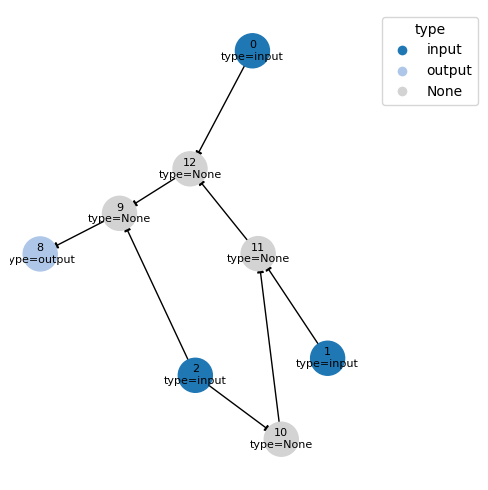

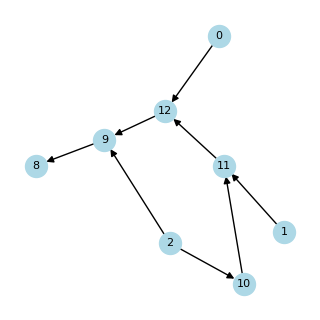

In [10]:

topology_plot_with_attrs(topology_networkx)

for topology_permutation in permuted_graphs:
    small_topology_plot(topology_permutation) 

In [11]:
permutation_index = 0

## Import experimental data

In [12]:
input_signals_list_small_molecules = [
    {0: 0.0278, 1: 0.0022, 2: 0.0042},  # First set of input signals
    {0: 0.0278, 1: 0.0022, 2: 2.0082},  # Second set of input signals
    {0: 0.0278, 1: 5.0543, 2: 0.0042},  # Third set of input signals
    {0: 0.0278, 1: 5.0543, 2: 2.0082},  # First set of input signals
    {0: 3.9239, 1: 0.0022, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 0.0022, 2: 2.0082},  # Third set of input signals    
    {0: 3.9239, 1: 5.0543, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 5.0543, 2: 2.0082},  # Third set of input signals  
]    

input_signals_list_binary = [
    {0: 0, 1: 0, 2: 0},  # First set of input signals
    {0: 0, 1: 0, 2: 1},  # Second set of input signals
    {0: 0, 1: 1, 2: 0},  # Third set of input signals
    {0: 0, 1: 1, 2: 1},  # First set of input signals
    {0: 1, 1: 0, 2: 0},  # Second set of input signals
    {0: 1, 1: 0, 2: 1},  # Third set of input signals    
    {0: 1, 1: 1, 2: 0},  # Second set of input signals
    {0: 1, 1: 1, 2: 1},  # Third set of input signals  
]   

# Data
repressor_data = {
    "Repressor": ["AmeR", "AmtR", "BetI", "BM3R1", "BM3R1", "BM3R1", "HlyIIR", "IcaRA", "LitR", "LmrA", 
                  "PhlF", "PhlF", "PhlF", "PsrA", "QacR", "QacR", "SrpR", "SrpR", "SrpR", "SrpR"],
    "RBS": ["F1", "A1", "E1", "B1", "B2", "B3", "H1", "I1", "L1", "N1", 
            "P1", "P2", "P3", "R1", "Q1", "Q2", "S1", "S2", "S3", "S4"],
    "ymaxa": [3.835, 5.036, 3.065, 0.543, 0.822, 0.704, 2.462, 3.558, 4.296, 2.152,
              3.901, 6.505, 6.794, 6.489, 3.744, 3.778, 1.216, 2.556, 2.547, 3.314],
    "ymina": [1.06, 0.091, 1e-14, 0.002, 1e-14, 1e-14, 0.057, 1e-14, 0.074, 0.183,
              0.01, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14],
    "Ka": [0.122, 0.022, 0.363, 0.051, 0.285, 0.261, 1e-14, 0.186, 1e-14, 1e-14,
          1e-14, 0.16, 0.167, 0.305, 0.126, 0.456, 1e-14, 0.224, 0.4, 0.108],
    "n": [1.306, 1.308, 1.833, 2.042, 1.685, 1.768, 2.596, 1.085, 1.696, 2.095,
          4, 2.237, 2.01, 1.54, 1.706, 1.979, 1.66, 1.337, 1.569, 1.344],
    "Toxicity (RPU)": ["-", "-", "-", "-", "-", "-", 4.06525, 0.47094, "-", "-", 
                       "-", "-", "-", "-", 4.06525, "-", "-", "-", "-", "-"]
}

# Create DataFrame
cello_v1_hill_function_parameters = pd.DataFrame(repressor_data)

cello_v1_hill_function_parameters

protein_groups = [
    {3, 4, 5},
    {10, 11, 12},
    {14, 15},
    {16, 17, 18, 19},
]

# Load the JSON file
file_path = '/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/gate_toxicity_POSTECH.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract all gate toxicity data
gate_toxicity_data = [item for item in data if item.get("collection") == "gate_toxicity"]

# Convert the list of dictionaries into a DataFrame
gate_toxicity_df = pd.DataFrame(gate_toxicity_data)

gate_toxicity_df

,collection,gate_name,input,growth
0,gate_toxicity,F1_AmeR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.936601827, 0.929528441, 0.927586207, 0.9..."
1,gate_toxicity,A1_AmtR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.005567327, 0.987403446, 1.01189251, 1.01..."
2,gate_toxicity,E1_BetI,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.465830721, 1.017868339, 1.023301985, 1.0..."
3,gate_toxicity,B1_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.992753623, 0.971014493, 0.992914654, 0.9..."
4,gate_toxicity,B2_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.978445044, 1.001274554, 1.019855551, 0.9..."
5,gate_toxicity,B3_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.971657754, 0.970707071, 1.015062389, 0.9..."
6,gate_toxicity,H1_HlyIIR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.931501911, 0.945850458, 0.941163746, 0.9..."
7,gate_toxicity,I1_IcaRA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.019887906, 1.026628502, 1.028642482, 1.0..."
8,gate_toxicity,L1_LitR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.034190532, 1.017241379, 1.034190532, 1.0..."
9,gate_toxicity,N1_LmrA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.948325359, 0.884901648, 0.884237108, 0.8..."


### Adquire data from objective objective function 

#### Load possible permutations without repeating repressor

In [13]:
gate_count, info = energy_score(topology_networkx, check_implicit_OR_existence_v3)
print(f"Gate count: {gate_count}")
print(f"Info: {info}")

Gate count: 4
Info: {'num_nodes': 8, 'num_inputs': 3, 'num_outputs': 1, 'max_removal': 0, 'best_pattern_key': None}


In [14]:
try:
    BASE_DIR = Path(__file__).resolve().parent.parent    
except NameError:
    BASE_DIR = Path.cwd().parent                          

file_path = BASE_DIR / "Designing complex biological circuits with deep neural networks" / "dgd" / "data" / "gate_permutations" / f"valid_permutations_{gate_count}_gates.h5"
#file_path = BASE_DIR / "data" / "gate_permutations" / f"valid_permutations_{gate_count}_gates.h5"

list_of_gates_indices = list(range(len(cello_v1_hill_function_parameters)))
if compute_valid_permutations:
    print("Computing valid gate permutations")
    valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
    save_valid_permutations(valid_permutations, file_path)
else:
    if file_path.is_file():           
        print(f"Found: {file_path}")
        print("Loading valid gate permutations")
        valid_permutations = load_valid_permutations(file_path)
        
    else:
        print(f"Missing: {file_path}")
        print("Computing valid gate permutations because file does not exist")   
        valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
        save_valid_permutations(valid_permutations, file_path)   
        
print(f"Total valid permutations: {len(valid_permutations)}")
print("Example permutation:", valid_permutations[0] if valid_permutations else "No permutations found")

Found: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/gate_permutations/valid_permutations_4_gates.h5
Loading valid gate permutations
Total valid permutations: 74736
Example permutation: (0, 1, 2, 3)


#### Adquire trainning data (multiple cores)

In [15]:
def save_accumulated_results(accumulated_results, file_number, output_dir):
    """
    Save accumulated results to a file
    
    Parameters:
    -----------
    accumulated_results : list
        List of results to save
    file_number : int
        Current file number for naming
    output_dir : str
        Directory to save the file
        
    Returns:
    --------
    list
        Empty list to reset accumulator
    """
    output_file = os.path.join(output_dir, f"results_large_batch_{file_number}.pkl")
    try:
        with open(output_file, 'wb') as f:
            pickle.dump(accumulated_results, f)
        print(f"Successfully saved {len(accumulated_results):,} solutions to {output_file}")
    except Exception as e:
        print(f"Error saving file {output_file}: {str(e)}")
    return []  # Return empty list to reset accumulator

def process_permutation_batch(batch_data):
    """
    Process a single batch of permutations
    """
    batch_id, adj_matrix, cello_params, input_signals_small, input_signals_binary, gate_toxicity_df, permutations = batch_data
    
    batch_results = []
    for current_solution in permutations:
        # Create test graph
        Gtest = assign_representations_with_io_nodes_3(
            adj_matrix,
            cello_params,
            current_solution
        )
        
        # Calculate toxicity
        toxicity_score, _ = calculate_toxicity_score(
            input_signals_small,
            Gtest,
            gate_toxicity_df
        )
        
        # Simulate logic
        actual_logic = simulate_signal_propagation(
            Gtest,
            input_signals_small
        )
        expected_logic = simulate_signal_propagation_binary(
            Gtest,
            input_signals_binary
        )
        
        # Calculate scores
        current_score = calculate_circuit_score(expected_logic, actual_logic)
        roadblocking_flag = is_roadblocking(Gtest)
        
        batch_results.append({
            'circuit_score': current_score,
            'toxicity_score': toxicity_score,
            'roadblocking_flag': roadblocking_flag[0],
            'permutation': current_solution
        })
    
    return batch_id, batch_results


def parallel_process_circuits(adj_matrix, valid_permutations, cello_params,
                            input_signals_small, input_signals_binary,
                            gate_toxicity_df, output_dir,
                            num_samples=2000000, batch_size=1000,
                            solutions_per_file=None):
    """
    Process a random subset of circuit solutions using all available cores
    and save results in configurable large chunks
    
    Parameters:
    -----------
    ... [previous parameters] ...
    solutions_per_file : int, optional
        Number of solutions to accumulate before saving to a file.
        If None, automatically sets to num_samples/10 (default)
        Min value is batch_size, max value is num_samples
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Set default solutions_per_file if not specified
    if solutions_per_file is None:
        solutions_per_file = num_samples // 10  # Default to 10 files total
    else:
        # Ensure solutions_per_file is between batch_size and num_samples
        solutions_per_file = max(batch_size, min(solutions_per_file, num_samples))
    
    num_cores = multiprocessing.cpu_count()
    print(f"Utilizing all {num_cores} cores for parallel processing")
    print(f"Solutions per file: {solutions_per_file:,}")
    print(f"Expected number of files: {num_samples // solutions_per_file + bool(num_samples % solutions_per_file)}")
    
    # Generate random indices for the subset
    print(f"Selecting {num_samples:,} random solutions from {len(valid_permutations):,} valid permutations")
    random_indices = random.sample(range(len(valid_permutations)), num_samples)
    selected_permutations = [valid_permutations[i] for i in random_indices]
    
    # Find the highest file number already saved
    existing_files = [f for f in os.listdir(output_dir) 
                     if f.startswith("results_large_batch_") and f.endswith(".pkl")]
    current_file_number = 0
    if existing_files:
        max_file_num = max(int(f.split('_')[-1].split('.')[0]) for f in existing_files)
        current_file_number = max_file_num + 1
    
    # Calculate total solutions already processed
    solutions_processed = current_file_number * solutions_per_file
    if solutions_processed >= num_samples:
        print("All solutions have already been processed")
        return
    
    start_time = time.time()
    
    # Prepare common data
    common_data = (adj_matrix, cello_params, input_signals_small, 
                  input_signals_binary, gate_toxicity_df)
    
    # Create batches for remaining solutions
    remaining_permutations = selected_permutations[solutions_processed:]
    total_batches = (len(remaining_permutations) + batch_size - 1) // batch_size
    
    # Prepare all batch data
    batch_data_list = []
    for batch_number in range(total_batches):
        start_idx = batch_number * batch_size
        end_idx = min(start_idx + batch_size, len(remaining_permutations))
        current_batch_permutations = remaining_permutations[start_idx:end_idx]
        
        batch_data = (batch_number,) + common_data + (current_batch_permutations,)
        batch_data_list.append(batch_data)
    
    print(f"Processing {len(batch_data_list)} batches using {num_cores} cores")
    
    accumulated_results = []
    processed_solutions = solutions_processed
    
    # Process all batches using all cores
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
        futures = [executor.submit(process_permutation_batch, batch_data) 
                  for batch_data in batch_data_list]
        
        with tqdm(total=len(batch_data_list), desc="Processing batches", 
                 unit="batch") as pbar:
            
            for future in concurrent.futures.as_completed(futures):
                try:
                    batch_id, batch_results = future.result()
                    accumulated_results.extend(batch_results)
                    processed_solutions += len(batch_results)
                    
                    # Save when we've accumulated enough solutions
                    if len(accumulated_results) >= solutions_per_file:
                        print(f"\nSaving file {current_file_number} with {len(accumulated_results):,} solutions...")
                        save_accumulated_results(
                            accumulated_results, 
                            current_file_number,
                            output_dir
                        )
                        accumulated_results = []  # Reset accumulator
                        current_file_number += 1
                    
                    # Update progress
                    elapsed_time = time.time() - start_time
                    remaining_batches = len(batch_data_list) - pbar.n
                    time_per_batch = elapsed_time / (pbar.n + 1)
                    remaining_time = remaining_batches * time_per_batch
                    
                    pbar.set_postfix({
                        'Solutions': f'{processed_solutions:,}/{num_samples:,}',
                        'Elapsed': f'{elapsed_time/60:.1f}min',
                        'Remaining': f'{remaining_time/60:.1f}min',
                        'Solutions/sec': f'{processed_solutions/elapsed_time:.1f}'
                    })
                    pbar.update(1)
                    
                except Exception as e:
                    print(f"\nError processing batch {batch_id}: {str(e)}")
                    continue
    
    # Save any remaining results
    if accumulated_results:
        print(f"\nSaving final file with {len(accumulated_results):,} solutions...")
        save_accumulated_results(accumulated_results, current_file_number, output_dir)
    
    total_time = time.time() - start_time
    
    print("\nProcessing completed!")
    print(f"Total solutions processed: {processed_solutions:,}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Average processing speed: {processed_solutions/total_time:.1f} solutions/second")
    print(f"Total files created: {current_file_number + 1}")
    
    return {
        'total_solutions_processed': processed_solutions,
        'total_time': total_time,
        'output_directory': output_dir,
        'solutions_per_second': processed_solutions/total_time,
        'total_files': current_file_number + 1
    }

Plot and check basic graph atritubes

In [16]:
Gi = permuted_graphs[0]
list(Gi.nodes(data = True))

[(0, {'type': 'input'}),
 (1, {'type': 'input'}),
 (2, {'type': 'input'}),
 (8, {'type': 'output'}),
 (9, {}),
 (10, {}),
 (11, {}),
 (12, {})]

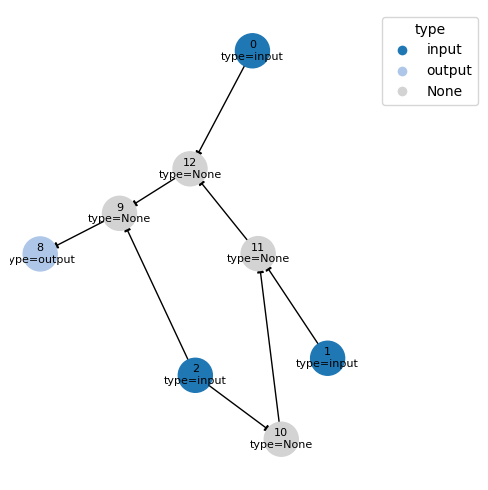

In [17]:
topology_plot_with_attrs(Gi)

Check how the graph is converted to adj matrix and then back to graph

In [18]:
nodelist = sorted(Gi.nodes())
list(sorted(Gi.nodes(data = True)))

[(0, {'type': 'input'}),
 (1, {'type': 'input'}),
 (2, {'type': 'input'}),
 (8, {'type': 'output'}),
 (9, {}),
 (10, {}),
 (11, {}),
 (12, {})]

In [19]:
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()
#adj_matrix

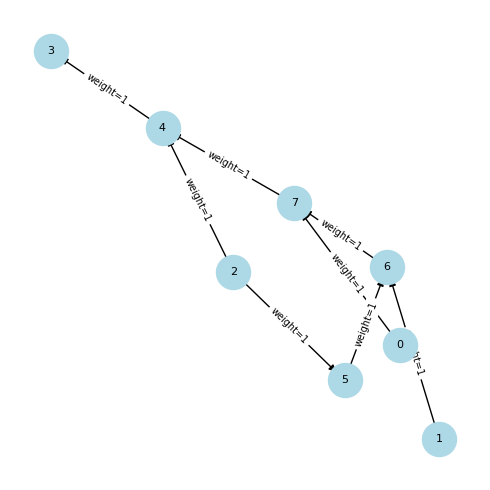

In [20]:
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Remove disconnected nodes (nodes with neither incoming nor outgoing edges)
disconnected_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
G.remove_nodes_from(disconnected_nodes)


topology_plot_with_attrs(G, seed = 41)




In [21]:
list(G.nodes(data = True))

[(0, {}), (1, {}), (2, {}), (3, {}), (4, {}), (5, {}), (6, {}), (7, {})]

In [22]:
input_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]
output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

# Filter nodes that are neither inputs nor outputs
non_io_nodes = [node for node in G.nodes() if node not in input_nodes and node not in output_nodes]
non_io_nodes

[4, 5, 6, 7]

In [23]:
stop

NameError: name 'stop' is not defined

Basic check of whether passing the adj matrix or graph gives the same gate assignment

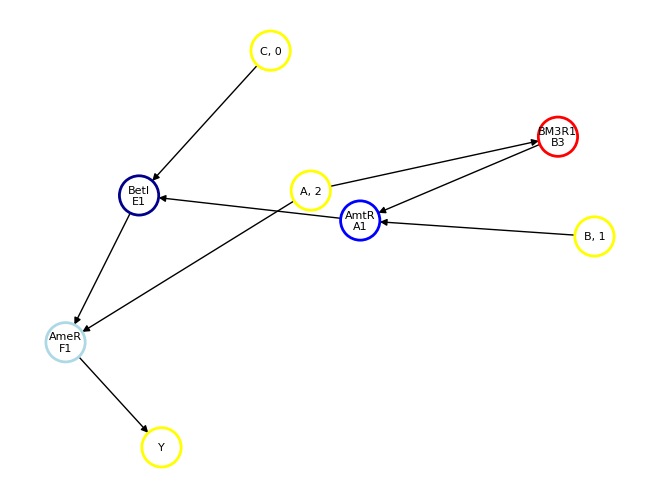

2.918236807421548

In [24]:
Gi = permuted_graphs[0]

node_representation_indices = valid_permutations[1000]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()
G = assign_representations_with_io_nodes_3(adj_matrix, cello_v1_hill_function_parameters, node_representation_indices)
draw_network_with_colors_and_labels_from_G(G, seed = 3)

actual_logic = simulate_signal_propagation(
    G,
    input_signals_list_small_molecules
)
expected_logic = simulate_signal_propagation_binary(
    G,
    input_signals_list_binary
)

# Calculate scores
current_score = calculate_circuit_score(expected_logic, actual_logic)
current_score

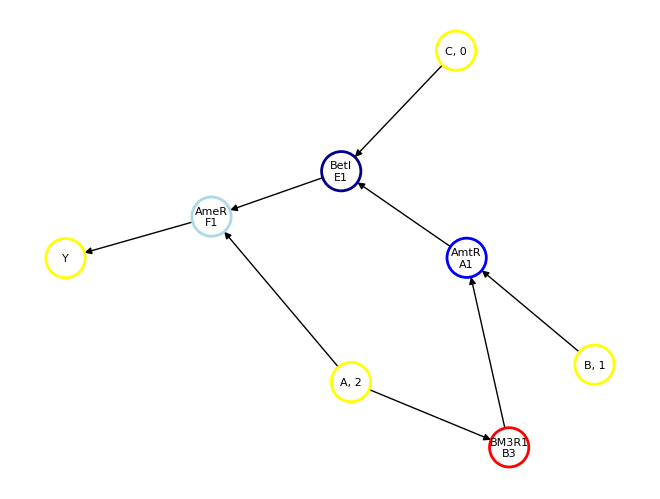

2.918236807421548

In [25]:
G2 = assign_representations_with_io_nodes_3_DiGraph(Gi, cello_v1_hill_function_parameters, node_representation_indices, topological_sort = False)
draw_network_with_colors_and_labels_from_G(G2)
actual_logic = simulate_signal_propagation(
    G2,
    input_signals_list_small_molecules
)
expected_logic = simulate_signal_propagation_binary(
    G2,
    input_signals_list_binary
)

# Calculate scores
current_score2 = calculate_circuit_score(expected_logic, actual_logic)
current_score2

Test to check whether providing the adj matrix or the graph give the same circuit score results and in the same order

In [26]:
len(valid_permutations)

74736

In [27]:
import random
import numpy as np
from tqdm import tqdm        # pip install tqdm  (if you don't have it already)

# ─── configuration ────────────────────────────────────────────────────────────
n            = 0                                       # graph index to test
sample_size  = 10000                                     # how many permutations
atol, rtol   = 1e-9, 1e-12                             # float comparison tol

# ─── prepare data ─────────────────────────────────────────────────────────────
Gi           = permuted_graphs[n]
all_indices  = list(range(len(valid_permutations)))
sample_ms    = random.sample(all_indices,
                             min(sample_size, len(all_indices)))

mismatches   = []                                      # collect failures

# ─── main loop with progress bar ──────────────────────────────────────────────
for m in tqdm(sample_ms, desc=f"n={n} checking permutations"):
    node_representation_indices = valid_permutations[m]

    # ── approach 1 ────────────────────────────────────────────────────────────
    nodelist   = sorted(Gi.nodes())
    adj_dense  = nx.to_numpy_array(Gi, nodelist=nodelist)
    G1         = assign_representations_with_io_nodes_3(
                     adj_dense,
                     cello_v1_hill_function_parameters,
                     node_representation_indices)
    actual1    = simulate_signal_propagation(
                     G1, input_signals_list_small_molecules)
    expected1  = simulate_signal_propagation_binary(
                     G1, input_signals_list_binary)
    score1     = calculate_circuit_score(expected1, actual1)

    # ── approach 2 ────────────────────────────────────────────────────────────
    G2         = assign_representations_with_io_nodes_3_DiGraph(
                     Gi,
                     cello_v1_hill_function_parameters,
                     node_representation_indices,
                     topological_sort=False)
    actual2    = simulate_signal_propagation(
                     G2, input_signals_list_small_molecules)
    expected2  = simulate_signal_propagation_binary(
                     G2, input_signals_list_binary)
    score2     = calculate_circuit_score(expected2, actual2)

    # ── compare ───────────────────────────────────────────────────────────────
    if not np.isclose(score1, score2, atol=atol, rtol=rtol):
        print(f"[n={n}, m={m}] mismatch  →  score1={score1:.6g}, score2={score2:.6g}")
        mismatches.append(m)

# ─── summary ─────────────────────────────────────────────────────────────────
if mismatches:
    print(f"\n{len(mismatches)} / {len(sample_ms)} sampled permutations differed ⇒ {mismatches}")
else:
    print(f"\nAll {len(sample_ms)} sampled permutations match for n={n}  ✔")


n=0 checking permutations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 253.71it/s]


All 10000 sampled permutations match for n=0  ✔


Test to check whether providing the graph and sorting by label or by topological order gives the same results, but iin different order

In [28]:
import numpy as np
from tqdm import tqdm                 # pip install tqdm  if needed

# ─── pick the permuted graph to test ────────────────────────────────────────
n  = 0
Gi = permuted_graphs[n]

scores_no_topo  = []                  # keep only the scores, not the keys
scores_with_topo = []

# ─── main loop over *all* permutations with progress bar ───────────────────
for m, node_representation_indices in tqdm(
        list(enumerate(valid_permutations)),
        desc=f"n={n} permutations"):
    
    # ----- build with topological_sort = False -----------------------------
    G_no = assign_representations_with_io_nodes_3_DiGraph(
               Gi,
               cello_v1_hill_function_parameters,
               node_representation_indices,
               topological_sort=False)
    actual_no   = simulate_signal_propagation(
                     G_no, input_signals_list_small_molecules)
    expected_no = simulate_signal_propagation_binary(
                     G_no, input_signals_list_binary)
    scores_no_topo.append(
        calculate_circuit_score(expected_no, actual_no)
    )

    # ----- build with topological_sort = True ------------------------------
    G_to = assign_representations_with_io_nodes_3_DiGraph(
               Gi,
               cello_v1_hill_function_parameters,
               node_representation_indices,
               topological_sort=True)
    actual_to   = simulate_signal_propagation(
                     G_to, input_signals_list_small_molecules)
    expected_to = simulate_signal_propagation_binary(
                     G_to, input_signals_list_binary)
    scores_with_topo.append(
        calculate_circuit_score(expected_to, actual_to)
    )

# ─── order-insensitive comparison of the two score lists --------------------
if len(scores_no_topo) != len(scores_with_topo):
    raise RuntimeError("Score lists have different lengths — logic error")

# sort both lists so we can compare element-wise
sorted_no  = sorted(scores_no_topo)
sorted_to  = sorted(scores_with_topo)

mismatches = [
    i for i, (s1, s2) in enumerate(zip(sorted_no, sorted_to))
    if not np.isclose(s1, s2, atol=1e-9, rtol=1e-12)
]

# ─── summary ───────────────────────────────────────────────────────────────
if mismatches:
    print(f"\n{len(mismatches)} out of {len(sorted_no)} circuit scores differ "
          f"(order-insensitive check failed).")
else:
    print(f"\nAll {len(sorted_no)} circuit scores match for n={n} ✔")


n=0 permutations: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74736/74736 [04:41<00:00, 265.32it/s]



All 74736 circuit scores match for n=0 ✔


Permuted graphs 0: (0, 1, 2)
Permuted graphs 1: (0, 2, 1)
Permuted graphs 2: (1, 0, 2)
Permuted graphs 3: (1, 2, 0)
Permuted graphs 4: (2, 0, 1)
Permuted graphs 5: (2, 1, 0)

In [34]:
for i in range(0, len(permuted_graphs)):
    nodes = list(nx.topological_sort(permuted_graphs[i]))
    print(nodes)
    adj_dense = nx.adjacency_matrix(Gi, nodelist=nodes).toarray()
    adj = np.asarray(resize_matrix(adj_dense, 10), dtype=np.float32)
    adj

[0, 1, 2, 10, 11, 12, 9, 8]


In [35]:
len(permuted_graphs)

1

In [ ]:
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

'''
# Run parallel processing with custom file size
results_summary = parallel_process_circuits(
    adj_matrix=adj_matrix,
    valid_permutations=valid_permutations,
    cello_params=cello_v1_hill_function_parameters,
    input_signals_small=input_signals_list_small_molecules,
    input_signals_binary=input_signals_list_binary,
    gate_toxicity_df=gate_toxicity_df,
    output_dir=Path(output_dir)/ f"circuit_results{circuit_name}_{selected_graph}_{permutation_index}",
    num_samples=num_samples,           # Total solutions to process
    batch_size=batch_size,              # Size of each processing batch
    solutions_per_file=solutions_per_file     # Save every 500,000 solutions
    )
'''

In [ ]:
stop

Keeping this code blow to see what is done

### Load training data

In [ ]:

def load_circuit_results(output_dir):
    """
    Load all circuit results from batch files in the specified directory.
    
    Parameters:
    -----------
    output_dir : str
        Directory containing the batch result files
        
    Returns:
    --------
    tuple
        (all_permutations, all_toxicity_scores, all_circuit_scores, all_roadblocking_flags)
    """
    # Get list of all result files (now using the correct filename pattern)
    files = [f for f in os.listdir(output_dir) 
             if f.startswith("results_large_batch_") and f.endswith(".pkl")]
    files.sort(key=lambda x: int(x[len("results_large_batch_"):-len(".pkl")]))
    
    # Initialize lists to store the data
    all_permutations = []
    all_toxicity_scores = []
    all_circuit_scores = []
    all_roadblocking_flags = []
    
    # Count total number of results for statistics
    total_results = 0
    
    # Load all results with a progress bar
    print(f"Found {len(files)} batch files to load")
    
    if len(files) == 0:
        print(f"No files found in directory: {output_dir}")
        print("Make sure the directory is correct and contains files with pattern 'results_large_batch_*.pkl'")
        return np.array([]), np.array([]), np.array([]), np.array([])
    
    for file in tqdm(files, desc="Loading results"):
        try:
            with open(os.path.join(output_dir, file), 'rb') as f:
                results = pickle.load(f)
                for result in results:
                    all_permutations.append(result['permutation'])
                    all_toxicity_scores.append(result['toxicity_score'])
                    all_circuit_scores.append(result['circuit_score'])
                    all_roadblocking_flags.append(result['roadblocking_flag'])
                total_results += len(results)
                
            # Print progress for large files
            if (total_results % 100000) == 0:
                print(f"\nProcessed {total_results:,} solutions so far...")
                
        except Exception as e:
            print(f"Error loading file {file}: {str(e)}")
            continue
    
    if total_results == 0:
        print("No results were successfully loaded")
        return np.array([]), np.array([]), np.array([]), np.array([])
    
    # Convert lists to numpy arrays for better memory efficiency
    all_permutations = np.array(all_permutations)
    all_toxicity_scores = np.array(all_toxicity_scores)
    all_circuit_scores = np.array(all_circuit_scores)
    all_roadblocking_flags = np.array(all_roadblocking_flags)
    
    # Print summary statistics
    print("\nLoading completed:")
    print(f"Total results loaded: {total_results:,}")
    print(f"Unique permutations: {len(np.unique(all_permutations, axis=0)):,}")
    print(f"Average circuit score: {np.mean(all_circuit_scores):.3f}")
    print(f"Average toxicity score: {np.mean(all_toxicity_scores):.3f}")
    print(f"Roadblocking percentage: {(np.sum(all_roadblocking_flags) / len(all_roadblocking_flags) * 100):.1f}%")
    
    return (all_permutations, all_toxicity_scores, all_circuit_scores, all_roadblocking_flags)



In [ ]:
# Load all results
(permutations, toxicity_scores, circuit_scores, roadblocking_flags) = load_circuit_results(Path(output_dir)/ f"circuit_results{circuit_name}_{selected_graph}_{permutation_index}")

if len(permutations) > 0:
    # Print data shape summary
    print("\nData shape summary:")
    print(f"Permutations shape: {permutations.shape}")
    print(f"Toxicity scores shape: {toxicity_scores.shape}")
    print(f"Circuit scores shape: {circuit_scores.shape}")
    print(f"Roadblocking flags shape: {roadblocking_flags.shape}")

### List top biological designs in the training data

In [ ]:
no_roadblock_mask_training_data = ~roadblocking_flags
permutations_no_roadblocking_training_data = permutations[no_roadblock_mask_training_data]
circuit_scores_no_roadblocking_training_data = circuit_scores[no_roadblock_mask_training_data]
toxicity_scores_no_roadblocking_training_data = toxicity_scores[no_roadblock_mask_training_data]
roadblocking_flags_no_roadblocking_training_data = roadblocking_flags[no_roadblock_mask_training_data]

toxicity_filter_training_data = toxicity_scores_no_roadblocking_training_data >= 0.75
permutations_no_roadblocking_toxicity_filtered_training_data = permutations_no_roadblocking_training_data[toxicity_filter_training_data]
circuit_scores_no_roadblocking_toxicity_filtered_training_data = circuit_scores_no_roadblocking_training_data[toxicity_filter_training_data]
toxicity_scores_no_roadblocking_toxicity_filtered_training_data = toxicity_scores_no_roadblocking_training_data[toxicity_filter_training_data]
roadblocking_flags_no_roadblocking_toxicity_filtered_training_data = roadblocking_flags_no_roadblocking_training_data[toxicity_filter_training_data]

print(circuit_scores_no_roadblocking_toxicity_filtered_training_data)

In [ ]:
# Find top N circuit scores
N_training_data = 20  # Change this number to get more or fewer top scores
top_n_indices_training_data = np.argsort(circuit_scores_no_roadblocking_toxicity_filtered_training_data)[-N_training_data:][::-1]  # Get indices of top N scores in descending order

print(f"\nTop {N_training_data} Circuit Scores (no roadblocking, toxicity > 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

# Store highest score details for later
highest_score_details_training_data = {}

for rank, idx in enumerate(top_n_indices_training_data, 1):
    
    corresponding_index_training_data = idx

    best_permutation_training_data = permutations_no_roadblocking_toxicity_filtered_training_data[corresponding_index_training_data]

    roadblock_flag_training_data = roadblocking_flags_no_roadblocking_toxicity_filtered_training_data[corresponding_index_training_data]

    print(f"{rank:4d} | {circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx]:12.4f} | "
          f"{toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx]:13.4f} | "
          f"{str(roadblock_flag_training_data):11} | {best_permutation_training_data}")

    # Store details for rank 1
    if rank == 1:
        highest_score_details_training_data = {
            'circuit_score': circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx],
            'toxicity_score': toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx],
            'roadblocking': roadblock_flag_training_data,
            'permutation': best_permutation_training_data
        }

# Print detailed information for highest scoring design after the table
print("\n" + "="*50)
print("Detailed information for highest scoring design:")
print("="*50)
print(f"Highest actual circuit score: {highest_score_details_training_data['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details_training_data['toxicity_score']}")
print(f"Roadblocking: {highest_score_details_training_data['roadblocking']}")
print(f"Permutation: {highest_score_details_training_data['permutation']}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.tight_layout(pad=4.0)  # Add space between subplots

# Data preparation
ranks = list(range(1, N_training_data + 1))
circuit_scores_training_data_top = circuit_scores_no_roadblocking_toxicity_filtered_training_data[top_n_indices_training_data]
toxicity_scores_training_data_top = toxicity_scores_no_roadblocking_toxicity_filtered_training_data[top_n_indices_training_data]

# Plot 1: Circuit Scores
bars1 = ax1.bar(ranks, circuit_scores_training_data_top, color='royalblue', alpha=0.7)
ax1.set_title('Top Circuit Scores by Rank (No Roadblocking, Toxicity > 0.75)', fontsize=12, pad=15)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Circuit Score')
ax1.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=0)

# Plot 2: Toxicity Scores
bars2 = ax2.bar(ranks, toxicity_scores_training_data_top, color='mediumseagreen', alpha=0.7)
ax2.set_title('Corresponding Toxicity Scores', fontsize=12, pad=15)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Toxicity Score')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=0)

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Analysis of Top Performing Circuits (Filtered for No Roadblocking & Toxicity)', fontsize=14, y=1.02)

# Save figure if needed
# plt.savefig('top_circuits_analysis_filtered.png', dpi=300, bbox_inches='tight')

plt.show()

# Print some statistics
print("\nStatistics Summary:")
print("-" * 50)
print(f"Circuit Scores - Mean: {np.mean(circuit_scores_training_data_top):.3f}, Std: {np.std(circuit_scores_training_data_top):.3f}")
print(f"Toxicity Scores - Mean: {np.mean(toxicity_scores_training_data_top):.3f}, Std: {np.std(toxicity_scores_training_data_top):.3f}")

## Define model

In [ ]:
# Model Definition
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionNN, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

### Prepare data for training 

In [ ]:
X_all = np.array(permutations).astype(np.float32)  # Convert all_permutations to a NumPy array
y_all = np.column_stack((toxicity_scores, circuit_scores)).astype(np.float32)  # Convert to a NumPy array
roadblocking_flags = np.array(roadblocking_flags)  # Convert all_roadblocking_flags to a NumPy array

num_classes = len(cello_v1_hill_function_parameters)
num_biological_parts = gate_count

In [ ]:
# Data Preparation and Filter by circuit score and roadblocking
filter_mask = (y_all[:, 1] > 0) & (roadblocking_flags == False)
X_all_filtered = X_all[filter_mask]
y_all_circuit_scores_filtered = y_all[filter_mask, 1]
y_all_toxicity_scores_filtered = y_all[filter_mask, 0]

print("Data " ,len(X_all_filtered))

#Subsample randomly and maintain order of data

# Check if we have enough samples and generate indices for subsampling
if len(X_all_filtered) >= subsample_size:
    # Get random indices and sort them to maintain order
    subsample_indices = np.sort(np.random.choice(len(X_all_filtered), subsample_size, replace=False))
else:
    print(f"Warning: Requested {subsample_size} samples, but only {len(X_all_filtered)} are available after filtering.")
    subsample_indices = np.arange(len(X_all_filtered))  # Simply use all indices in order
    subsample_size = len(X_all_filtered)  # Adjust subsample_size to the available data
    
# Subsample the data
X_all_filtered_subsampled = X_all_filtered[subsample_indices]
y_all_circuit_scores_filtered_subsampled = y_all_circuit_scores_filtered[subsample_indices]
y_all_toxicity_scores_filtered_subsampled = y_all_toxicity_scores_filtered[subsample_indices]

# Convert X to PyTorch tensor and perform one-hot encoding
X_all_filtered_subsampled_tensor = th.from_numpy(X_all_filtered_subsampled).long()
X_all_filtered_subsampled_tensor_one_hot = F.one_hot(X_all_filtered_subsampled_tensor, num_classes=num_classes).float()

# Convert y to PyTorch tensors
y_all_circuit_scores_filtered_subsampled_tensor = th.from_numpy(y_all_circuit_scores_filtered_subsampled).float().unsqueeze(1)
y_all_toxicity_scores_filtered_subsampled_tensor = th.from_numpy(y_all_toxicity_scores_filtered_subsampled).float().unsqueeze(1)

# Split the data
train_ratio = 0.8
num_samples = X_all_filtered_subsampled_tensor_one_hot.shape[0]
num_train = int(train_ratio * num_samples)

np.random.seed(42)
train_indices = np.random.choice(num_samples, num_train, replace=False)
train_mask = np.zeros(num_samples, dtype=bool)
train_mask[train_indices] = True

X_training_set = X_all_filtered_subsampled_tensor_one_hot[train_mask]
y_circuit_scores_training_set = y_all_circuit_scores_filtered_subsampled_tensor[train_mask]
y_toxicity_scores_training_set = y_all_toxicity_scores_filtered_subsampled_tensor[train_mask]

X_test_set = X_all_filtered_subsampled_tensor_one_hot[~train_mask]
y_circuit_scores_test_set = y_all_circuit_scores_filtered_subsampled_tensor[~train_mask]
y_toxicity_scores_test_set = y_all_toxicity_scores_filtered_subsampled_tensor[~train_mask]

# Device Setup
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model Initialization
input_size = num_biological_parts * num_classes
hidden_size = 200
output_size = 1

model_circuit_score = RegressionNN(input_size, hidden_size, output_size).to(device)
model_toxicity_score = RegressionNN(input_size, hidden_size, output_size).to(device)

'''
if th.cuda.device_count() > 1:
    print(f"Using {th.cuda.device_count()} GPUs")
    model_circuit_score = nn.DataParallel(model_circuit_score)
    model_toxicity_score = nn.DataParallel(model_toxicity_score)
'''

criterion = nn.MSELoss()
optimizer_circuit_score = optim.Adam(model_circuit_score.parameters(), lr=0.001)
optimizer_toxicity_score = optim.Adam(model_toxicity_score.parameters(), lr=0.001)

# Shuffle training data
shuffle_indices = th.randperm(X_training_set.size(0))
X_training_set_shuffled = X_training_set[shuffle_indices].to(device)
y_circuit_scores_training_set_shuffled = y_circuit_scores_training_set[shuffle_indices].to(device)
y_toxicity_scores_training_set_shuffled = y_toxicity_scores_training_set[shuffle_indices].to(device)

X_test_set = X_test_set.to(device)
y_circuit_scores_test_set = y_circuit_scores_test_set.to(device)
y_toxicity_scores_test_set = y_toxicity_scores_test_set.to(device)

### Trainning

In [ ]:
# Training Loop
def train_model(model, X_train, y_train, X_test, y_test, optimizer, criterion, num_epochs):
    train_losses = []
    test_losses = []
    pbar = tqdm(range(num_epochs), desc="Training Progress")
    for epoch in pbar:
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train)
        train_loss = criterion(outputs, y_train)
        
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())
        
        model.eval()
        with th.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
        
        test_losses.append(test_loss.item())
        
        pbar.set_postfix({'Train Loss': train_loss.item(), 'Test Loss': test_loss.item()})
    
    return train_losses, test_losses

In [ ]:

model_circuit_score_losses = train_model(model_circuit_score, X_training_set_shuffled, y_circuit_scores_training_set_shuffled, 
                             X_test_set, y_circuit_scores_test_set, optimizer_circuit_score, criterion, num_epochs)

model_toxicity_score_losses = train_model(model_toxicity_score, X_training_set_shuffled, y_toxicity_scores_training_set_shuffled, 
                              X_test_set, y_toxicity_scores_test_set, optimizer_toxicity_score, criterion, num_epochs)

In [ ]:
# Set the style for publication-quality plots
plt.style.use('seaborn-paper')
# Increase font sizes and set consistent font family
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'sans-serif',  # Changed from 'Arial' to 'sans-serif'
    'font.sans-serif': ['DejaVu Sans', 'Helvetica', 'Verdana'],  # Fallback fonts
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 10
})

# Create figure with larger size and higher DPI
plt.figure(figsize=(8, 3), dpi=300)

# First subplot
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), model_circuit_score_losses[0], label='Training Loss', 
         linewidth=2, color='#2E86C1')  # Professional blue color
plt.plot(range(num_epochs), model_circuit_score_losses[1], label='Validation Loss', 
         linewidth=2, color='#E67E22')  # Professional orange color
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Mean Squared Error', fontweight='bold')
plt.title('Circuit Score Model', pad=15)
plt.legend(frameon=True, fancybox=False, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)

# Second subplot
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), model_toxicity_score_losses[0], label='Training Loss',
         linewidth=2, color='#2E86C1')
plt.plot(range(num_epochs), model_toxicity_score_losses[1], label='Validation Loss',
         linewidth=2, color='#E67E22')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Mean Squared Error', fontweight='bold')
plt.title('Toxicity Score Model', pad=15)
plt.legend(frameon=True, fancybox=False, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

### After training, save the models

In [ ]:
def save_model(model, filepath):
    # If the model is wrapped in DataParallel, we need to save the underlying model's state_dict
    if isinstance(model, nn.DataParallel):
        th.save(model.module.state_dict(), filepath)
    else:
        th.save(model.state_dict(), filepath)

# Save the circuit-score model
save_model(
    model_circuit_score,
    Path(output_dir) / f"model_circuit_score_{circuit_name}_{selected_graph}_{permutation_index}.pth"
)

# Save the toxicity-score model
save_model(
    model_toxicity_score,
    Path(output_dir) / f"model_toxicity_score_{circuit_name}_{selected_graph}_{permutation_index}.pth"
)

###  Load trained model 

In [ ]:
# Initialize the models
input_size = num_biological_parts * num_classes # Must match the input size used during training
hidden_size = 200    # Must match the hidden size used during training
output_size = 1      # Must match the output size used during training

model_circuit_score = RegressionNN(input_size, hidden_size, output_size)
model_toxicity_score = RegressionNN(input_size, hidden_size, output_size)

# Load the state dictionaries
def load_model(model, filepath):
    state_dict = th.load(filepath, map_location=th.device('cpu'))
    model.load_state_dict(state_dict)

# Save the circuit-score model
load_model(
    model_circuit_score,
    Path(output_dir) / f"model_circuit_score_{circuit_name}_{selected_graph}_{permutation_index}.pth"
)

# Save the toxicity-score model
load_model(
    model_toxicity_score,
    Path(output_dir) / f"model_toxicity_score_{circuit_name}_{selected_graph}_{permutation_index}.pth"
)

## Predictions

In [ ]:

X_valid_permutations = np.array(valid_permutations).astype(np.float32)  # Convert all_permutations to a NumPy array
# Convert X_filtered to PyTorch tensor and perform one-hot encoding
X_valid_permutations_tensor = th.from_numpy(X_valid_permutations).long()
X_valid_permutations_tensor_one_hot = F.one_hot(X_valid_permutations_tensor, num_classes=20).float()

print("Converted to tensors")

In [ ]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_circuit_score  = model_circuit_score.to(device)
model_toxicity_score = model_toxicity_score.to(device)

# Prediction
model_circuit_score.eval()
model_toxicity_score.eval()

# Calculate the start time
print("Performing predictions")
with th.no_grad():
    
    start = time.time()
    
    X = X_valid_permutations_tensor_one_hot.to(device)
    
    y_predicted_circuit_scores = model_circuit_score(X).cpu().numpy().flatten()
    y_predicted_toxicity_scores = model_toxicity_score(X).cpu().numpy().flatten()
    
    # Calculate the end time and time taken
    end = time.time()
    duration = end - start
    print("")
    print("Done performing predictions. Time to make predictions: ", duration)

In [ ]:
import numpy as np
import plotly.graph_objects as go

idx        = np.arange(len(y_predicted_circuit_scores))      # X-axis (sample index)
tox_pred   = np.asarray(y_predicted_toxicity_scores)         # Y-axis (predicted toxicity)
circ_pred  = np.asarray(y_predicted_circuit_scores)          # Z-axis (predicted circuit)

tox_actual  = []       # Y-axis (actual toxicity)
circ_actual = []       # Z-axis (actual circuit)

step = 1                           # keep 1 point out of every 10
sel  = slice(None, None, step)          # same as [::step]

# Apply the same selection to all arrays
idx_sub         = idx[sel]
tox_pred_sub    = tox_pred[sel]
circ_pred_sub   = circ_pred[sel]
tox_actual_sub  = tox_actual[sel]
circ_actual_sub = circ_actual[sel]

len(idx)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # registers “3d”
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker


plt.rcParams.update({
    "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
    "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
})

edge_col, edge_w = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72

fig = plt.figure(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)
ax  = fig.add_subplot(111, projection="3d")


'''
orig   = cm.get_cmap("coolwarm")
cmap   = mcolors.LinearSegmentedColormap.from_list(
            "cmap_reduced", orig(np.linspace(0.00, 1.00, 256)))
norm   = mcolors.Normalize(vmin=circ_pred_sub.min(),
                           vmax=circ_pred_sub.max())
'''


coldest   = "#1D70F6"   
cold   = "#7399D6"   
middle = "#FBB5A1"   
warm   = "#FA8F72"   
warmest   = "#E15832" 


cw_mid = mcolors.LinearSegmentedColormap.from_list(
    "coolwarm_mid",
    [(0.00, coldest),
     (0.20, cold),
     (0.50, middle),
     (0.75, warm),
     (1.00, warmest)],
    N=256)                     

cmap = cw_mid                       
norm = mcolors.Normalize(vmin=circ_pred_sub.min(),
                         vmax=circ_pred_sub.max())



ax.scatter(idx_sub, tox_pred_sub, circ_pred_sub,
           s=1,
           c=circ_pred_sub,
           cmap=cmap, norm=norm,
           alpha=1,
           edgecolors="none",
           rasterized=True,          
           label="Predicted")

fig.subplots_adjust(right=0.80)

ax.set_xlim(idx_sub.min(),  idx_sub.max())
ax.set_ylim(tox_pred_sub.min(), tox_pred_sub.max())
ax.set_zlim(circ_pred_sub.min(), circ_pred_sub.max())


for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.line.set_color(edge_col); axis.line.set_linewidth(edge_w)
    axis._axinfo["tick"]["inward_factor"]  = 0.2
    axis._axinfo["tick"]["outward_factor"] = 0.0
    axis.set_tick_params(direction="out", length=4,
                         width=edge_w, colors=edge_col, pad=1)
    axis.label.set_color(edge_col)

for pane in (ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane):
    pane.set_edgecolor(edge_col); pane.set_linewidth(edge_w)
ax.set_facecolor("white"); ax.grid(False)


ax.view_init(elev=10, azim=115)

x_angle = -ax.azim
for lbl in ax.get_xticklabels():
    lbl.set_rotation(x_angle)
    lbl.set_rotation_mode('anchor')
    lbl.set_ha('center'); lbl.set_va('center')

y_angle = 10 - ax.elev
for lbl in ax.get_yticklabels():
    lbl.set_rotation(y_angle)
    lbl.set_rotation_mode('anchor')
    lbl.set_ha('right'); lbl.set_va('center')

ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))


ax.set_xlabel("Sample index",             labelpad=0)
ax.set_ylabel("Toxicity score",           labelpad=-6)
ax.set_zlabel("Biological circuit score", labelpad=-8)
ax.legend(loc="upper left")

plt.tight_layout(rect=[0, 0, 0.80, 1])  

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(
        mappable, ax=ax,
        fraction=0.03,      
        pad=0.06,           
        shrink=0.65,        
        aspect=20)          
cbar.ax.tick_params(labelsize=6)
cbar.set_label("Biological circuit score", fontsize=6)


ax.tick_params(axis='x', which='major', pad=2.0)   
ax.tick_params(axis='y', which='major', pad=-1.0)   
ax.tick_params(axis='z', which='major', pad=-4.0)  


plt.show()


In [ ]:
fig.savefig("scatter_cube6parts.svg",  dpi=450, bbox_inches="tight")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker


plt.rcParams.update({
    "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
    "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
})

edge_col, edge_w = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72

# ── colour-map for third variable -----------------------------------
orig   = cm.get_cmap("coolwarm")
cmap   = mcolors.LinearSegmentedColormap.from_list(
            "cmap_reduced", orig(np.linspace(0.00, 0.00, 256)))
norm   = mcolors.Normalize(vmin=circ_pred_sub.min(),
                           vmax=circ_pred_sub.max())

# ── figure & scatter panels ----------------------------------------
fig, (ax_xy, ax_xz) = plt.subplots(
    1, 2,
    figsize=(pt_to_in(270), pt_to_in(110)),   # 270 pt × 135 pt
    dpi=150,
    sharex=False, sharey=False
)

# leave ≈17 % of the width empty on the right for the colour-bar
fig.subplots_adjust(right=0.83, wspace=0.28)    # tweak wspace as you like

# first panel: X–Y
sc1 = ax_xy.scatter(idx_sub, tox_pred_sub,
                    s=1, c=circ_pred_sub, cmap=cmap, norm=norm,
                    alpha=1, edgecolors="none", rasterized=True)
ax_xy.set_xlabel("Sample index", labelpad=4)
ax_xy.set_ylabel("Toxicity score", labelpad=4)

# second panel: X–Z
sc2 = ax_xz.scatter(idx_sub, circ_pred_sub,
                    s=1, c=circ_pred_sub, cmap=cmap, norm=norm,
                    alpha=1, edgecolors="none", rasterized=True)
ax_xz.set_xlabel("Sample index",             labelpad=4)
ax_xz.set_ylabel("Biological circuit score", labelpad=4)

# ── dedicated colour-bar axis --------------------------------------
# [left, bottom, width, height]   (all fractions of the figure)
cax = fig.add_axes([0.86, 0.15, 0.03, 0.70])    # 3 % wide strip
cb  = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cb.ax.tick_params(labelsize=6)
cb.set_label("Biological circuit score", fontsize=6, labelpad=4)

# ── common axis styling --------------------------------------------
for ax, ydata in [(ax_xy, tox_pred_sub), (ax_xz, circ_pred_sub)]:
    ax.set_xlim(idx_sub.min(), idx_sub.max())
    ax.set_ylim(ydata.min(),    ydata.max())
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))

    # mimic cube-edge look
    for spine in ax.spines.values():
        spine.set_color(edge_col)
        spine.set_linewidth(edge_w)

    ax.tick_params(direction="out", length=4, width=edge_w,
                   colors=edge_col, pad=1)
    ax.xaxis.label.set_color(edge_col)
    ax.yaxis.label.set_color(edge_col)

# ── legend ----------------------------------------------------------
#ax_xy.legend([sc1], ["Predicted"], loc="upper left", markerscale=5)

# ── final layout ----------------------------------------------------
plt.tight_layout(rect=[0, 0, 0.83, 1])   # respect th_


In [ ]:
stop

### Characterize performance on the test set

In [ ]:
# Get model predictions on test set
model_circuit_score.eval()
model_toxicity_score.eval()

# Move test data and models to available device
model_circuit_score = model_circuit_score.to(device)
model_toxicity_score = model_toxicity_score.to(device)
X_test_set = X_test_set.to(device)

# Make predictions
with th.no_grad():
    test_pred_circuit = model_circuit_score(X_test_set)
    test_pred_toxicity = model_toxicity_score(X_test_set)

# Convert everything to numpy arrays for plotting
test_pred_circuit = test_pred_circuit.cpu().numpy().flatten()
test_pred_toxicity = test_pred_toxicity.cpu().numpy().flatten()
test_actual_circuit = y_circuit_scores_test_set.cpu().numpy().flatten()
test_actual_toxicity = y_toxicity_scores_test_set.cpu().numpy().flatten()

In [ ]:
'''
# Create 2D comparison plots
import matplotlib as mpl
plt.style.use('seaborn-paper')
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "axes.linewidth": 1.5,
    "lines.linewidth": 2,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 12,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False
})
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

# Circuit Score comparison plot
ax1.scatter(test_actual_circuit, test_pred_circuit, 
           alpha=1, s=1, color='blue')
ax1.plot([min(test_actual_circuit), max(test_actual_circuit)], [min(test_actual_circuit), max(test_actual_circuit)], 'r--', label='Perfect Prediction')
ax1.set_xlabel('Actual Circuit Score', fontweight='bold')
ax1.set_ylabel('Predicted Circuit Score', fontweight='bold')
ax1.set_title('Circuit Score: Predicted vs Actual (Test Set)')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Toxicity Score comparison plot
ax2.scatter(test_actual_toxicity, test_pred_toxicity, 
           alpha=1, s=1, color='blue')
ax2.plot([min(test_actual_toxicity), max(test_actual_toxicity)],[min(test_actual_toxicity), max(test_actual_toxicity)], 'r--', label='Perfect Prediction')
ax2.set_xlabel('Actual Toxicity Score', fontweight='bold')
ax2.set_ylabel('Predicted Toxicity Score', fontweight='bold')
ax2.set_title('Toxicity Score: Predicted vs Actual (Test Set)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# Add correlation coefficients
test_circuit_corr = np.corrcoef(test_actual_circuit, test_pred_circuit)[0,1]
test_toxicity_corr = np.corrcoef(test_actual_toxicity, test_pred_toxicity)[0,1]

plt.tight_layout()
plt.savefig('test_set_prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistical measures
from sklearn.metrics import mean_squared_error, r2_score

# Circuit Score metrics
test_circuit_mse = mean_squared_error(test_actual_circuit, test_pred_circuit)
test_circuit_rmse = np.sqrt(test_circuit_mse)
test_circuit_r2 = r2_score(test_actual_circuit, test_pred_circuit)

# Toxicity Score metrics
test_toxicity_mse = mean_squared_error(test_actual_toxicity, test_pred_toxicity)
test_toxicity_rmse = np.sqrt(test_toxicity_mse)
test_toxicity_r2 = r2_score(test_actual_toxicity, test_pred_toxicity)

print("\nTest Set Circuit Score Metrics:")
print(f"MSE: {test_circuit_mse:.4f}")
print(f"RMSE: {test_circuit_rmse:.4f}")
print(f"R² Score: {test_circuit_r2:.4f}")
print(f"Correlation Coefficient: {test_circuit_corr:.4f}")

print("\nTest Set Toxicity Score Metrics:")
print(f"MSE: {test_toxicity_mse:.4f}")
print(f"RMSE: {test_toxicity_rmse:.4f}")
print(f"R² Score: {test_toxicity_r2:.4f}")
print(f"Correlation Coefficient: {test_toxicity_corr:.4f}")
'''


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams.update({
    "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
    "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
})

edge_col, edge_w = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72           

fig, (ax_circ, ax_tox) = plt.subplots(
    1, 2,
    figsize=(pt_to_in(210), pt_to_in(100)),  
    dpi=250,
    sharex=False, sharey=False
)
fig.subplots_adjust(wspace=0.30)

ax_circ.scatter(test_actual_circuit, test_pred_circuit,
                s=4,  c="#417FF1", alpha=1, edgecolors="none", rasterized=False)
ax_circ.plot([test_actual_circuit.min(), test_actual_circuit.max()],
             [test_actual_circuit.min(), test_actual_circuit.max()],
             linestyle="--", linewidth=0.5, color="#E06C4B", label="Perfect prediction")
ax_circ.set_xlabel("Actual circuit score",  labelpad=4)
ax_circ.set_ylabel("Predicted circuit score", labelpad=4)
ax_circ.set_title("Circuit: predicted vs actual")
ax_circ.legend(loc="upper left", markerscale=5)

ax_tox.scatter(test_actual_toxicity, test_pred_toxicity,
               s=4,  c="#417FF1", alpha=1, edgecolors="none", rasterized=False)
ax_tox.plot([test_actual_toxicity.min(), test_actual_toxicity.max()],
            [test_actual_toxicity.min(), test_actual_toxicity.max()],
            linestyle="--", linewidth=0.5, color="#E06C4B", label="Perfect prediction")
ax_tox.set_xlabel("Actual toxicity score",   labelpad=4)
ax_tox.set_ylabel("Predicted toxicity score", labelpad=4)
ax_tox.set_title("Toxicity: predicted vs actual")
ax_tox.legend(loc="upper left", markerscale=5)

for ax in (ax_circ, ax_tox):
    for spine in ax.spines.values():
        spine.set_color(edge_col); spine.set_linewidth(edge_w)

    ax.tick_params(direction="out", length=4, width=edge_w,
                   colors=edge_col, pad=1)
    ax.xaxis.label.set_color(edge_col)
    ax.yaxis.label.set_color(edge_col)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))

plt.tight_layout()
plt.show()

test_circuit_corr     = np.corrcoef(test_actual_circuit,  test_pred_circuit)[0, 1]
test_toxicity_corr    = np.corrcoef(test_actual_toxicity, test_pred_toxicity)[0, 1]
test_circuit_mse      = mean_squared_error(test_actual_circuit,  test_pred_circuit)
test_toxicity_mse     = mean_squared_error(test_actual_toxicity, test_pred_toxicity)

print("\nTest-set circuit score:")
print(f"  MSE  = {test_circuit_mse:.4f}")
print(f"  RMSE = {np.sqrt(test_circuit_mse):.4f}")
print(f"  R²   = {r2_score(test_actual_circuit,  test_pred_circuit):.4f}")
print(f"  ρ    = {test_circuit_corr:.4f}")

print("\nTest-set toxicity score:")
print(f"  MSE  = {test_toxicity_mse:.4f}")
print(f"  RMSE = {np.sqrt(test_toxicity_mse):.4f}")
print(f"  R²   = {r2_score(test_actual_toxicity, test_pred_toxicity):.4f}")
print(f"  ρ    = {test_toxicity_corr:.4f}")


In [ ]:
fig.savefig("Predictions on test set6part.svg",  dpi=450, bbox_inches="tight")

In [ ]:
'''

# ------------------------------------------------------------------
# 1.  GraphPad-style cosmetics  (copy-paste from your single-line plot)
# ------------------------------------------------------------------
plt.rcParams.update({
    "font.family"      : "sans-serif",
    "font.sans-serif"  : ["DejaVu Sans"],   # pick any installed font
    "font.size"        : 6,
    "axes.labelsize"   : 14,
    "axes.titlesize"   : 16,
    "axes.linewidth"   : 1.5,
    "lines.linewidth"  : 2,
    "xtick.labelsize"  : 12,
    "ytick.labelsize"  : 12,
    "xtick.direction"  : "in",
    "ytick.direction"  : "in",
    "xtick.major.size" : 5,
    "ytick.major.size" : 5,
    "legend.fontsize"  : 12,
    "legend.frameon"   : False,
    "savefig.dpi"      : 300,
    "figure.dpi"       : 100,
    "figure.figsize"   : (8, 4),            # width x height, inches
    "axes.grid"        : False,
})

# ------------------------------------------------------------------
# 2.  Figure & axes
# ------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)

# Common scatter kwargs
scatter_kw = dict(
    s=30,                # ≈ 5 pt markers
    color='#417FF1',     # GraphPad-like blue
    edgecolors='black',  # thin outline
    linewidths=0.4,
    alpha=0.9
)

# ------------------------------------------------------------------
# 3.  Circuit-score panel
# ------------------------------------------------------------------
ax1.scatter(test_actual_circuit, test_pred_circuit, **scatter_kw)
lims = [min(test_actual_circuit), max(test_actual_circuit)]
ax1.plot(lims, lims, '--', color='gray', linewidth=1.2, label='y = x')
ax1.set_xlim(lims);  ax1.set_ylim(lims)

ax1.set_xlabel('Actual circuit score')
ax1.set_ylabel('Predicted circuit score')
ax1.set_title('Circuit score (test)')

# cosmetic touches
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', which='both', direction='in')
ax1.legend()

# ------------------------------------------------------------------
# 4.  Toxicity-score panel
# ------------------------------------------------------------------
ax2.scatter(test_actual_toxicity, test_pred_toxicity, **scatter_kw)
lims = [min(test_actual_toxicity), max(test_actual_toxicity)]
ax2.plot(lims, lims, '--', color='gray', linewidth=1.2, label='y = x')
ax2.set_xlim(lims);  ax2.set_ylim(lims)

ax2.set_xlabel('Actual toxicity score')
ax2.set_ylabel('Predicted toxicity score')
ax2.set_title('Toxicity score (test)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='both', direction='in')
ax2.legend()

# ------------------------------------------------------------------
# 5.  Optional correlation text
# ------------------------------------------------------------------
r_circ = np.corrcoef(test_actual_circuit, test_pred_circuit)[0, 1]
r_tox  = np.corrcoef(test_actual_toxicity, test_pred_toxicity)[0, 1]

ax1.text(0.05, 0.95, f'r = {r_circ:.2f}', transform=ax1.transAxes,
         ha='left', va='top', fontsize=11)
ax2.text(0.05, 0.95, f'r = {r_tox:.2f}', transform=ax2.transAxes,
         ha='left', va='top', fontsize=11)

# ------------------------------------------------------------------
# 6.  Save / show
# ------------------------------------------------------------------
plt.savefig('test_set_prediction_comparison_graphpad.svg',
            format='svg', bbox_inches='tight')
plt.show()
'''

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "Sample":  np.arange(len(test_actual_circuit)),
    "Toxicity (actual)":   test_actual_toxicity,
    "Circuit (actual)":    test_actual_circuit,
    "Toxicity (pred)":     test_pred_toxicity,
    "Circuit (pred)":      test_pred_circuit,
})

fig = px.scatter_3d(
    df,
    x="Sample",
    y="Toxicity (actual)",
    z="Circuit (actual)",
    color_discrete_sequence=["#417FF1"],
    opacity=0.85,
    symbol_sequence=["circle"],
    size=np.full(len(df), 5),               
)

fig.add_scatter3d(
    x=df["Sample"],
    y=df["Toxicity (pred)"],
    z=df["Circuit (pred)"],
    mode="markers",
    marker=dict(
        size=4,
        color="#E06C4B",
        opacity=0.85,
        line=dict(width=0.5, color="black"),
        symbol="diamond",
    ),
    name="Predicted",
)

fig.update_layout(
    scene=dict(
        xaxis_title="Sample index",
        yaxis_title="Toxicity score",
        zaxis_title="Circuit score",
        camera=dict(eye=dict(x=1.4, y=1.6, z=0.9)),  # nice angle
    ),
    legend=dict(x=0.02, y=0.98, bgcolor="rgba(255,255,255,0.0)"),
    margin=dict(l=0, r=0, b=0, t=40),
    title="Test-set: circuit vs toxicity (actual vs predicted)",
)
fig.show()


In [ ]:
# ---------------------------------------------------------------
# full_permutations : list / ndarray of ALL ~8.7 M permutations
# valid_permutations: the subset you kept for inference
# ---------------------------------------------------------------

# Build a lookup that says: permutation  →  its position in the full list
# (Using bytes as dict-keys is a quick, memory-light trick.)
perm2idx = {p.tobytes(): i for i, p in enumerate(full_permutations)}

# Translate each valid permutation into its global index
idx_global = np.fromiter((perm2idx[p.tobytes()] for p in valid_permutations),
                         dtype=np.int64, count=len(valid_permutations))



# ------------- prediction arrays already built -----------------
# test_pred_circuit  , test_pred_toxicity
# ---------------------------------------------------------------

fig = plt.figure(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)
ax  = fig.add_subplot(111, projection="3d")

coldest, cold, mid, warm, warmest = "#1D70F6", "#7399D6", "#FBB5A1", "#FA8F72", "#E15832"
cmap = mcolors.LinearSegmentedColormap.from_list(
    "coolwarm_mid", [(0.00, coldest), (0.20, cold),
                     (0.50, mid),    (0.75, warm), (1.00, warmest)], N=256)
norm = mcolors.Normalize(vmin=test_pred_circuit.min(),
                         vmax=test_pred_circuit.max())

ax.scatter(idx_global,                 # ← TRUE global sample index
           test_pred_toxicity,
           test_pred_circuit,
           s=1, c=test_pred_circuit,
           cmap=cmap, norm=norm,
           alpha=1, edgecolors="none", rasterized=True,
           label="Predicted (valid subset)")

ax.set_xlim(0, len(full_permutations) - 1)          # force 0 … 8.7 M
ax.set_ylim(test_pred_toxicity.min(), test_pred_toxicity.max())
ax.set_zlim(test_pred_circuit.min(),  test_pred_circuit.max())

# … keep the cosmetic code you already have (axes colours, grid off, view angle, c-bar) …
plt.show()


In [ ]:
np.arange(X_all.shape[0]) 

## Find top designs

#### Filter condition is where predicted circuit score is above a threshold

In [ ]:
filter_condition_for_circuit_score = y_predicted_circuit_scores > 2


#### Select and save permutations predicted to be high-performing

In [ ]:
gate_assignments_predicted_to_have_high_cricuit_score = X_valid_permutations[filter_condition_for_circuit_score]
# Save the array

np.save(Path(output_dir)/ f"gate_assignments_high_score_{circuit_name}_{selected_graph}_{permutation_index}.npy", gate_assignments_predicted_to_have_high_cricuit_score)


#### Load permutations predicted to be high-performing

In [ ]:
gate_assignments_predicted_to_have_high_cricuit_score = np.load(Path(output_dir) / f"gate_assignments_high_score_{circuit_name}_{selected_graph}_{permutation_index}.npy")

# Convert to list of tuples
gate_assignments_predicted_to_have_high_cricuit_score_list_of_tuples = [
    tuple(np.int64(x) for x in tup) 
    for tup in gate_assignments_predicted_to_have_high_cricuit_score
]


#### Calculate actual scores and save

In [ ]:
# Initialize your graph and get adjacency matrix
Gi = permuted_graphs[0]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

# Run parallel processing with custom file size
results_summary = parallel_process_circuits(
    adj_matrix=adj_matrix,
    valid_permutations=gate_assignments_predicted_to_have_high_cricuit_score_list_of_tuples,
    cello_params=cello_v1_hill_function_parameters,
    input_signals_small=input_signals_list_small_molecules,
    input_signals_binary=input_signals_list_binary,
    gate_toxicity_df=gate_toxicity_df,
    output_dir=Path(output_dir)/ f"high_performing_circuit_results{circuit_name}_{selected_graph}_{permutation_index}",
    num_samples=len(gate_assignments_predicted_to_have_high_cricuit_score_list_of_tuples),           # Total solutions to process
    batch_size=batch_size,              # Size of each processing batch
    solutions_per_file=solutions_per_file     # Save every 500,000 solutions
    )

#### Load actual scores if saved

In [ ]:
# Load all results
(permutations_high_performing, toxicity_scores_high_performing, 
 circuit_scores_high_performing, roadblocking_flags_high_performing) = load_circuit_results( Path(output_dir) / f"high_performing_circuit_results{circuit_name}_{selected_graph}_{permutation_index}")

if len(permutations) > 0:
    # Print data shape summary
    print("\nData shape summary:")
    print(f"Permutations shape: {permutations_high_performing.shape}")
    print(f"Toxicity scores shape: {toxicity_scores_high_performing.shape}")
    print(f"Circuit scores shape: {circuit_scores_high_performing.shape}")
    print(f"Roadblocking flags shape: {roadblocking_flags_high_performing.shape}")

### List top biological designs 

In [ ]:
no_roadblock_mask = ~roadblocking_flags_high_performing

In [ ]:
permutations_high_performing_no_roadblocking = permutations_high_performing[no_roadblock_mask]
circuit_scores_high_performing_no_roadblocking = circuit_scores_high_performing[no_roadblock_mask]
toxicity_scores_high_performing_no_roadblocking = toxicity_scores_high_performing[no_roadblock_mask]
roadblocking_flags_high_performing_no_roadblocking = roadblocking_flags_high_performing[no_roadblock_mask]

In [ ]:
toxicity_filter = toxicity_scores_high_performing_no_roadblocking >= 0.75

In [ ]:
permutations_high_performing_no_roadblocking_toxicity_filtered = permutations_high_performing_no_roadblocking[toxicity_filter]
circuit_scores_high_performing_no_roadblocking_toxicity_filtered = circuit_scores_high_performing_no_roadblocking[toxicity_filter]
toxicity_scores_high_performing_no_roadblocking_toxicity_filtered = toxicity_scores_high_performing_no_roadblocking[toxicity_filter]
roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered = roadblocking_flags_high_performing_no_roadblocking[toxicity_filter]

In [ ]:
print(circuit_scores_high_performing_no_roadblocking_toxicity_filtered)

### Search only for circuits without Bet NOR

In [ ]:
gate_max_incoming_signals = {
    "gate_max_incoming_signals": [2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
}

# Create DataFrame
gate_max_incoming_signals_df = pd.DataFrame(gate_max_incoming_signals)

In [ ]:
valid_NOR_NOT_assignments_flags = []

for perm in (permutations_high_performing_no_roadblocking_toxicity_filtered):
    Gtest = assign_representations_with_io_nodes_3(adj_matrix, cello_v1_hill_function_parameters, perm)
    valid_NOR_NOT_assignments_flags.append(validate_graph_incoming_signals(Gtest, cello_v1_hill_function_parameters, gate_max_incoming_signals_df))

In [ ]:
num_true = sum(valid_NOR_NOT_assignments_flags)
num_true

In [ ]:
N = 20

In [ ]:
# Get indices where validation flags are True
valid_indices = [i for i, flag in enumerate(valid_NOR_NOT_assignments_flags) if flag]

# Filter scores to only include valid circuits
top_n_indices = np.argsort([circuit_scores_high_performing_no_roadblocking_toxicity_filtered[i] for i in valid_indices])[-N:][::-1]
valid_indices_array = np.array(valid_indices)

print(f"\nTop {N} Valid Circuit Scores (no roadblocking, toxicity > 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

highest_score_details = {}
for rank, idx in enumerate(top_n_indices, 1):
    corresponding_index = valid_indices_array[idx]
    best_permutation = permutations_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]
    roadblock_flag = roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]
    
    print(f"{rank:4d} | {circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]:12.4f} | "
          f"{toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]:13.4f} | "
          f"{str(roadblock_flag):11} | {best_permutation}")
    
    if rank == 1:
        highest_score_details = {
            'circuit_score': circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index],
            'toxicity_score': toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index],
            'roadblocking': roadblock_flag,
            'permutation': best_permutation
        }

print("\n" + "="*50)
print("Detailed information for highest scoring valid design:")
print("="*50)
print(f"Highest actual circuit score: {highest_score_details['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details['toxicity_score']}")
print(f"Roadblocking: {highest_score_details['roadblocking']}")
print(f"Permutation: {highest_score_details['permutation']}")

In [ ]:
G = assign_representations_with_io_nodes_3(adj_matrix, cello_v1_hill_function_parameters, highest_score_details['permutation'])
draw_network_with_colors_and_labels_from_G(G)

Export to CSV

In [ ]:
rows = []
for rank, idx in enumerate(top_n_indices, 1):
    corr_idx = valid_indices_array[idx]
    rows.append({
        "Rank"            : rank,
        "Circuit Score"   : circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Toxicity Score"  : toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Roadblocking"    : roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Permutation"     : permutations_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
    })


csv_path = Path(output_dir) / f"top_valid_circuits_{circuit_name}_{selected_graph}_{permutation_index}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    writer.writerows(rows)

print(f"\n Saved {len(rows)} rows to {csv_path}")

## Previous code

In [ ]:
# Find top N circuit scores
N = 20  # Change this number to get more or fewer top scores
top_n_indices = np.argsort(circuit_scores_high_performing_no_roadblocking_toxicity_filtered)[-N:][::-1]  # Get indices of top N scores in descending order

print(f"\nTop {N} Circuit Scores (no roadblocking, toxicity > 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

# Store highest score details for later
highest_score_details = {}

for rank, idx in enumerate(top_n_indices, 1):
    # Get the corresponding index in the original filtered arrays
    corresponding_index = idx

    # Get permutation
    best_permutation = permutations_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]

    # Get roadblocking flag for this design
    roadblock_flag = roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]

    # Print formatted output
    print(f"{rank:4d} | {circuit_scores_high_performing_no_roadblocking_toxicity_filtered[idx]:12.4f} | "
          f"{toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[idx]:13.4f} | "
          f"{str(roadblock_flag):11} | {best_permutation}")

    # Store details for rank 1
    if rank == 1:
        highest_score_details = {
            'circuit_score': circuit_scores_high_performing_no_roadblocking_toxicity_filtered[idx],
            'toxicity_score': toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[idx],
            'roadblocking': roadblock_flag,
            #'predicted_circuit': y_pred_circuit_filtered[corresponding_index],
            #'predicted_toxicity': y_pred_toxicity_filtered[corresponding_index],
            'permutation': best_permutation
        }

# Print detailed information for highest scoring design after the table
print("\n" + "="*50)
print("Detailed information for highest scoring design:")
print("="*50)
print(f"Highest actual circuit score: {highest_score_details['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details['toxicity_score']}")
print(f"Roadblocking: {highest_score_details['roadblocking']}")
#print(f"Predicted circuit score: {highest_score_details['predicted_circuit']}")
#print(f"Predicted toxicity score: {highest_score_details['predicted_toxicity']}")
print(f"Permutation: {highest_score_details['permutation']}")

In [ ]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.tight_layout(pad=4.0)  # Add space between subplots

# Data preparation
ranks = list(range(1, N + 1))
circuit_scores = circuit_scores_high_performing_no_roadblocking_toxicity_filtered[top_n_indices]
toxicity_scores = toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[top_n_indices]

# Plot 1: Circuit Scores
bars1 = ax1.bar(ranks, circuit_scores, color='royalblue', alpha=0.7)
ax1.set_title('Top Circuit Scores by Rank', fontsize=12, pad=15)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Circuit Score')
ax1.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', rotation=0)

# Plot 2: Toxicity Scores
bars2 = ax2.bar(ranks, toxicity_scores, color='mediumseagreen', alpha=0.7)
ax2.set_title('Corresponding Toxicity Scores', fontsize=12, pad=15)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Toxicity Score')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', rotation=0)

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Analysis of Top Performing Circuits', fontsize=14, y=1.02)

# Save figure if needed
# plt.savefig('top_circuits_analysis.png', dpi=300, bbox_inches='tight')

plt.show()

# Optional: Print some statistics
print("\nStatistics Summary:")
print("-" * 50)
print(f"Circuit Scores - Mean: {np.mean(circuit_scores):.3f}, Std: {np.std(circuit_scores):.3f}")
print(f"Toxicity Scores - Mean: {np.mean(toxicity_scores):.3f}, Std: {np.std(toxicity_scores):.3f}")

#### Draw the top design

In [ ]:
G = assign_representations_with_io_nodes_3(adj_matrix, cello_v1_hill_function_parameters, highest_score_details['permutation'])
draw_network_with_colors_and_labels_from_G(G)